# [1] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\Sai charan\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
con = sqlite3.connect('final.sqlite')
final = pd.read_sql_query("""
SELECT * FROM Reviews order by Time
""", con) 
final_train = pd.read_sql_query("""
SELECT * FROM Reviews order by Time 
limit cast(0.7*(select count(*) from Reviews) as integer) 
""" , con) 
final_test = pd.read_sql_query("""
SELECT * FROM Reviews order by Time desc
limit cast(0.3*(select count(*) from Reviews) as integer) 
""" , con)

In [3]:
final.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
2,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
3,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
4,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [4]:
print(final.shape)
print(final_train.shape)
print(final_test.shape)

(364171, 12)
(254919, 12)
(109251, 12)


In [5]:
final_train.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
2,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
3,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
4,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


# BAG OF WORDS

In [6]:
count_vect = CountVectorizer() #in scikit-learn
final_train_X = count_vect.fit_transform(final_train['CleanedText'].values)
final_train_Y = final_train['Score'].values
final_test_X =  count_vect.transform(final_test['CleanedText'].values)
final_test_Y = final_test['Score']

C:\Users\Sai charan\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)



The optimal value of alpha is 1.00000000.


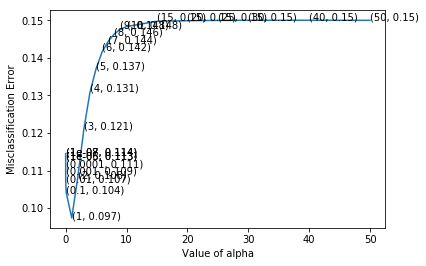

the misclassification error for each k value is :  [0.114 0.114 0.113 0.113 0.111 0.109 0.107 0.104 0.097 0.108 0.121 0.131
 0.137 0.142 0.144 0.146 0.148 0.148 0.15  0.15  0.15  0.15  0.15  0.15 ]


In [7]:
from sklearn import cross_validation
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.cross_validation import cross_val_score
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(final_train_X, final_train_Y, 
                                                                     test_size=0.3, random_state=42)

myList = list(range(1,50))
neighbors = list(filter(lambda x: x % 1 == 0, myList))
neighbors = [0.00000001,0.0000001, 0.000001,0.00001,0.0001,0.001,0.01,0.1,1,2,3,4,5,6,7,8,9,10,15,20,25,30,40,50]


cv_scores = []

for k in neighbors:
    nb = MultinomialNB(alpha=k)
    nb.fit(X_train, Y_train)
    #print(nb.predict(X_test[2:39]))
    scores = cross_val_score(nb, X_test, Y_test, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    #print((nb))

MSE = [1 - x for x in cv_scores]
#determining best k
optimal_alpha = neighbors[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is %.8f.' % optimal_alpha)

plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Value of alpha')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [8]:
# top 10  features
import operator
from nltk.probability import FreqDist, DictionaryProbDist, ELEProbDist, sum_logs
from nltk.classify.api import ClassifierI
from nltk.classify.naivebayes import NaiveBayesClassifier
nb = MultinomialNB(alpha=optimal_alpha).fit(final_train_X, final_train_Y)
pos_imp_features = nb.feature_log_prob_[1,:]
neg_imp_features = nb.feature_log_prob_[0,:]


imp_features = {}
feature_names= count_vect.get_feature_names()
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = pos_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("Postive top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])
    
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = neg_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("\n\nNegative top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])

Postive top 10 important features are:
('like', -4.444011085613443)
('tast', -4.51426792968355)
('good', -4.649293762950087)
('flavor', -4.670882981304331)
('love', -4.699096964570424)
('great', -4.719491079019004)
('use', -4.741244269360369)
('one', -4.797570713871195)
('product', -4.883810709990517)
('tea', -4.891354136409893)


Negative top 10 important features are:
('tast', -4.239537630748643)
('like', -4.320779248452499)
('product', -4.488506458708635)
('one', -4.763496894718443)
('flavor', -4.805309933663004)
('tri', -4.914608058527804)
('would', -4.9151140033906096)
('good', -5.071558697973897)
('coffe', -5.097334350731513)
('use', -5.1043419455480965)


In [9]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    
    B =(C/C.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    #representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    #representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Accuracy of the model at optimal hyperparameter alpha = 1 is:  89.557990%
Confusion matrix for the model is:


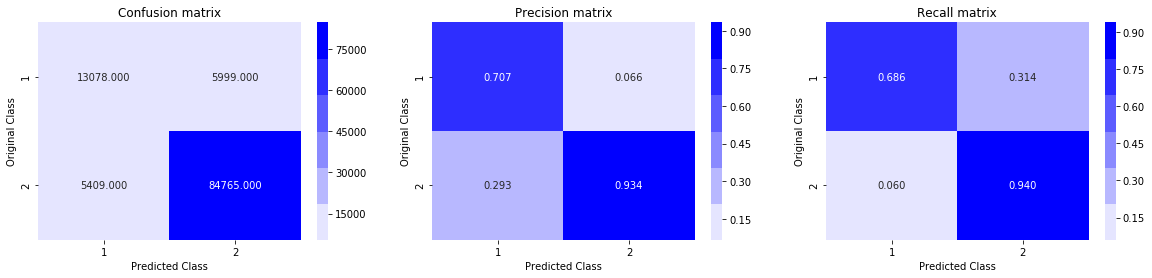

Recall value for the positive class of the model is: 0.9400159691263558
Precision value for the positive class of the model is: 0.9339055131990657
F1 score for the positive class of the model is: 0.9369507787197824


In [10]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
nb = MultinomialNB(alpha=optimal_alpha).fit(final_train_X, final_train_Y)
Y_pred = nb.predict(final_test_X)
Y_test_accuracy = accuracy_score(final_test_Y, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter alpha = %d is:  %f%%' % (optimal_alpha,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(final_test_Y, Y_pred)

rec_pre_f1 = precision_recall_fscore_support(final_test_Y, Y_pred)
print('Recall value for the positive class of the model is: %s'% rec_pre_f1[1][1])
print('Precision value for the positive class of the model is: %s'% rec_pre_f1[0][1])
print('F1 score for the positive class of the model is: %s'% rec_pre_f1[2][1])

In [11]:
print(final_train_X.shape)
print(final_test_X.shape)

(254919, 59194)
(109251, 59194)


# TF-IDF

In [12]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf_train_X = tf_idf_vect.fit_transform(final_train['CleanedText'].values)
final_tf_idf_train_Y = final_train['Score'].values
final_tf_idf_test_X = tf_idf_vect.transform(final_test['CleanedText'].values)
final_tf_idf_test_Y = final_test['Score'].values
print(final_tf_idf_train_X.get_shape())
print(final_tf_idf_train_Y.shape)
print(final_tf_idf_test_X.get_shape())
print(final_tf_idf_test_Y.shape)

(254919, 2307509)
(254919,)
(109251, 2307509)
(109251,)


In [13]:
features = tf_idf_vect.get_feature_names()
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf_train_X[1,:].toarray()[0],features,25)
print(top_tfidf)

            feature     tfidf
0         book song  0.177012
1      child sister  0.177012
2    school purchas  0.177012
3    preschool turn  0.177012
4   teach preschool  0.177012
5      whole school  0.177012
6      song student  0.177012
7       air televis  0.177012
8      sister later  0.177012
9              book  0.174366
10  children tradit  0.171386
11         use seri  0.171386
12         show air  0.171386
13     televis year  0.171386
14    thirti someth  0.171386
15    student teach  0.171386
16        ago child  0.167393
17    book children  0.167393
18      tradit live  0.167393
19       day thirti  0.167393
20        seri book  0.161767
21       along book  0.161767
22         see show  0.154678
23       turn whole  0.151037
24     later bought  0.148155



The optimal value of alpha is 0.00100000.


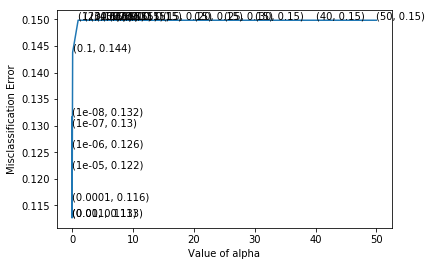

the misclassification error for each k value is :  [0.132 0.13  0.126 0.122 0.116 0.113 0.113 0.144 0.15  0.15  0.15  0.15
 0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15 ]


In [14]:
from sklearn import cross_validation
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.cross_validation import cross_val_score
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(final_tf_idf_train_X, final_tf_idf_train_Y, 
                                                                     test_size=0.3, random_state=42)

myList = list(range(1,50))
neighbors = list(filter(lambda x: x % 1 == 0, myList))
neighbors = [0.00000001,0.0000001, 0.000001,0.00001,0.0001,0.001,0.01,0.1,1,2,3,4,5,6,7,8,9,10,15,20,25,30,40,50]


cv_scores = []

for k in neighbors:
    nb = MultinomialNB(alpha=k)
    nb.fit(X_train, Y_train)
    scores = cross_val_score(nb, X_test, Y_test, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
MSE = [1 - x for x in cv_scores]
optimal_alpha = neighbors[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is %.8f.' % optimal_alpha)
 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Value of alpha')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [15]:
#finding top 10 features
import operator
from nltk.probability import FreqDist, DictionaryProbDist, ELEProbDist, sum_logs
from nltk.classify.api import ClassifierI
from nltk.classify.naivebayes import NaiveBayesClassifier
nb = MultinomialNB(alpha=optimal_alpha).fit(final_tf_idf_train_X, final_tf_idf_train_Y)
pos_imp_features = nb.feature_log_prob_[1,:]
neg_imp_features = nb.feature_log_prob_[0,:]


imp_features = {}
feature_names= tf_idf_vect.get_feature_names()
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = pos_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("Postive top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])
    
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = neg_imp_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("\n\nNegative top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])

Postive top 10 important features are:
('great', -6.214908305108226)
('love', -6.223800110468767)
('tast', -6.271516958483198)
('tea', -6.276004958192765)
('like', -6.280537022492241)
('good', -6.282728795103455)
('flavor', -6.342825825864094)
('coffe', -6.366835358668578)
('use', -6.447703493948013)
('product', -6.457243596923904)


Negative top 10 important features are:
('tast', -5.972647197482666)
('like', -6.115270308297991)
('product', -6.159475254340928)
('would', -6.459222687058151)
('flavor', -6.476005432312708)
('coffe', -6.479861593208945)
('one', -6.499791469080046)
('tri', -6.604188933571626)
('buy', -6.629491714450055)
('order', -6.6337315762164994)


Accuracy of the model at optimal hyperparameter alpha = 0.001000 is:  87.705376%
Confusion matrix for the model is:


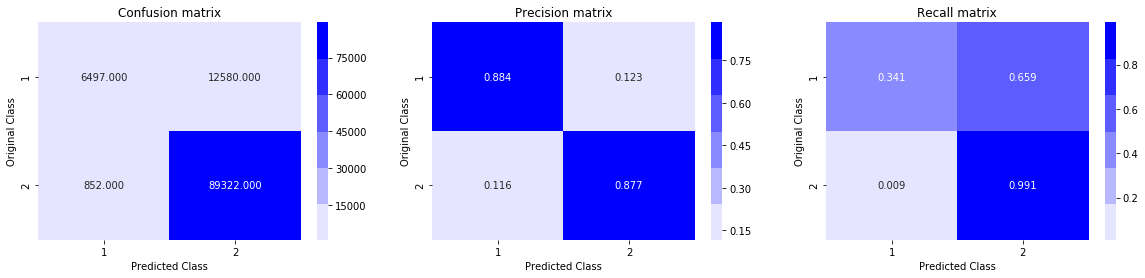

Recall value for the positive class of the model is: 0.9905516002395369
Precision value for the positive class of the model is: 0.8765480559753489
F1 score for the positive class of the model is: 0.9300693475499282


In [16]:
#confusion matrix,precision, recall, f1 score,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
nb = MultinomialNB(alpha=optimal_alpha).fit(final_tf_idf_train_X, final_tf_idf_train_Y)
Y_pred = nb.predict(final_tf_idf_test_X)
Y_test_accuracy = accuracy_score(final_tf_idf_test_Y, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter alpha = %f is:  %f%%' % (optimal_alpha,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(final_tf_idf_test_Y, Y_pred)

rec_pre_f1 = precision_recall_fscore_support(final_tf_idf_test_Y, Y_pred)
print('Recall value for the positive class of the model is: %s'% rec_pre_f1[1][1])
print('Precision value for the positive class of the model is: %s'% rec_pre_f1[0][1])
print('F1 score for the positive class of the model is: %s'% rec_pre_f1[2][1])